# Protein Sequence Classification on pfam dataset

## 1. Business Problem

### 1.1 Description

[Proteins](https://en.wikipedia.org/wiki/Protein) are large, complex biomolecules that play many critical roles in biological bodies. Proteins are made up of one or more long chains of [amino acids](https://en.wikipedia.org/wiki/Amino_acid) sequences. These Sequence are the arrangement of amino acids in a protein held together by [peptide bonds](https://en.wikipedia.org/wiki/Peptide_bond). Proteins can be made from [20](https://www.hornetjuice.com/amino-acids-types/) different kinds of amino acids, and the structure and function of each protein are determined by the kinds of amino acids used to make it and how they are arranged. 

Understanding this relationship between amino acid sequence and protein function is a long-standing problem in moleculer biology with far-reaching scientific implications. Can we use deep learning that learns the relationship between unaligned amino acid sequences and their functional annotations across all 17929 families of the Pfam database.

[Pfam](https://en.m.wikipedia.org/wiki/Pfam) is a database of [protein families](https://en.m.wikipedia.org/wiki/Protein_family) that includes their annotations and multiple sequence alignments.

__Problem Statement__
- Classification of protein's amino acid sequence to one of the protein family accession, based on PFam dataset.
- In other words, the task is: given the amino acid sequence of the protein domain, predict which class it belongs to.


### 1.2 Sources/Useful Links

- Source: [Pfam seed random split](https://www.kaggle.com/googleai/pfam-seed-random-split)
- Paper: [Using deep learning to annotate the protein universe](https://www.biorxiv.org/content/10.1101/626507v4.full).

### 1.3 Real world/Business Objectives and Constraints

Objectives
- Predict protein family accession from its amino acids sequence with high accuracy.

Constraints
- No strict latency concerns.

## 2. Machine Learning Problem

### 2.1 Data

#### 2.1.1 Data Overview

- `sequence`: These are usually the input features to the model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.

- `family_accession`: These are usually the labels for the model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

- `sequence_name`: Sequence name, in the form "uniprot_accession_id/start_index-end_index". 

- `aligned_sequence`: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

- `family_id`: One word name for family. 

#### 2.1.2 Example Data point



```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
```



#### 2.1.3 Data split

- We have been provided with already done random split(train, val, test) of pfam dataset.
  - Train - 80% (For training the models).
  - Val - 10% (For hyperparameter tuning/model validation).
  - Test - 10% (For acessing the model performance).

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine learning Problem

It is a multi class classification problem, for a given sequence of amino acids we need to predict its family accession.

#### 2.2.2 Performance Metric

- Multi class log loss
- Accuracy

## 3. Exploratory Data Analysis

### Importing Libraries

In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras import regularizers
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D

Using TensorFlow backend.


In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Loading Data

In [4]:
data_path = 'drive/My Drive/Case_Study/pfam/random_split/'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [0]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [0]:
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

### Basic Statistics

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086741 entries, 0 to 13514
Data columns (total 5 columns):
family_id           1086741 non-null object
sequence_name       1086741 non-null object
family_accession    1086741 non-null object
aligned_sequence    1086741 non-null object
sequence            1086741 non-null object
dtypes: object(5)
memory usage: 49.7+ MB


In [8]:
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [9]:
# considering less data because of memory issues.

train = df_train[0:300000]
val = df_val[0:10000]
test = df_test[0:10000]

train.shape, val.shape, test.shape

((300000, 5), (10000, 5), (10000, 5))

In [10]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [11]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids.

train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [12]:
train_unq = np.unique(train['family_accession'].values)
val_unq = np.unique(val['family_accession'].values)
test_unq = np.unique(test['family_accession'].values)

print('Number of unique classes in Train: ', len(train_unq))
print('Number of unique classes in Val: ', len(val_unq))
print('Number of unique classes in Test: ', len(test_unq))

Number of unique classes in Train:  16341
Number of unique classes in Val:  4921
Number of unique classes in Test:  4934


In [13]:
# Number of unique classes in all splits
unique_classes = np.intersect1d(np.intersect1d(train_unq, val_unq), test_unq)
print('Total number of unique classes in all splits', len(unique_classes))

Total number of unique classes in all splits 2900


In [14]:
unique_classes

array(['PF00003.22', 'PF00006.25', 'PF00008.27', ..., 'PF18846.1',
       'PF18859.1', 'PF18863.1'], dtype=object)

In [15]:
# Considering observations which are in the total unique_classes.

train = train.loc[train['family_accession'].isin(unique_classes)].reset_index()
val = val.loc[val['family_accession'].isin(unique_classes)].reset_index()
test = test.loc[test['family_accession'].isin(unique_classes)].reset_index()

print('Data size after considering unique classes for each split')
print('Train size: ', len(train))
print('Val size: ', len(val))
print('Test size: ', len(test))

Data size after considering unique classes for each split
Train size:  174649
Val size:  7359
Test size:  7370


### Sequence Counts

In [0]:
# Length of sequence in train data.
train['seq_char_count']= train['sequence'].apply(lambda x: len(x))
val['seq_char_count']= val['sequence'].apply(lambda x: len(x))
test['seq_char_count']= test['sequence'].apply(lambda x: len(x))

In [0]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

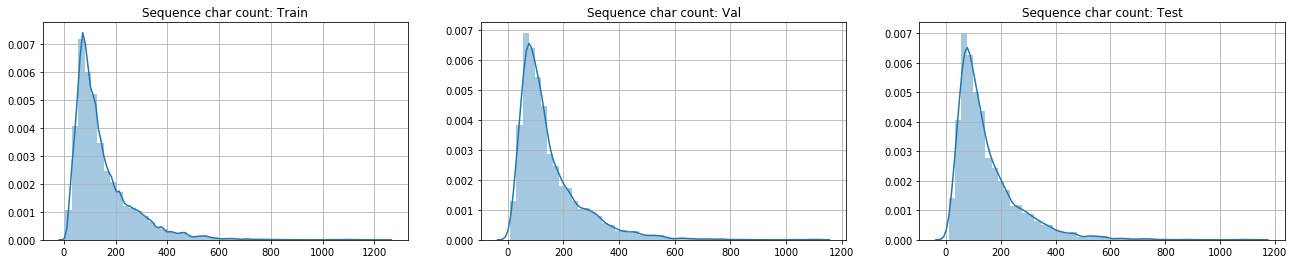

In [0]:
plt.subplot(1, 3, 1)
plot_seq_count(train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observation__
- Most of the unaligned amino acid sequences have character counts in the range of 50-200.

### Sequence Code Frequency

In [0]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [0]:
# train code sequence
train_code_freq = get_code_freq(train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 23


,Code,Freq
0,L,2616177
1,A,2302173
2,G,1925519
3,V,1904620
4,E,1640466
5,I,1631716
6,S,1549521
7,R,1444935
8,D,1428929
9,T,1393216


In [0]:
# val code sequence
val_code_freq = get_code_freq(val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 21


,Code,Freq
0,L,111112
1,A,97123
2,G,80620
3,V,80522
4,E,70100
5,I,68433
6,S,67606
7,R,61732
8,D,60886
9,T,59174


In [0]:
# test code sequence
test_code_freq = get_code_freq(test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 22


,Code,Freq
0,L,111426
1,A,95599
2,G,80220
3,V,80195
4,E,70177
5,I,69094
6,S,66894
7,R,61300
8,D,61157
9,T,59452


In [0]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

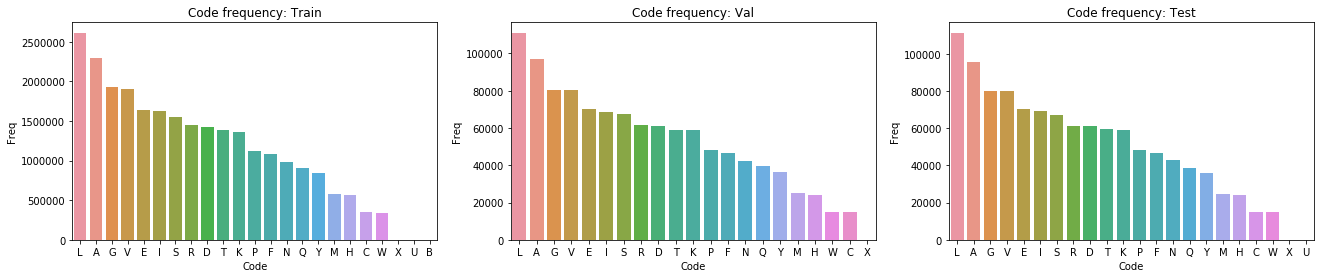

In [0]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__
- Most frequent amino acid code is L followed by A, G, V.
- As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [0]:
train.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    951
LRR_1              554
Acetyltransf_7     505
His_kinase         457
Lum_binding        447
Bac_transf         427
Chromate_transp    379
DNA_binding_1      368
DnaJ_CXXCXGXG      357
Lipase_GDSL_2      351
dtype: int64

In [0]:
# protein family_accession with most sequences

train.groupby('family_accession').size().sort_values(ascending=False).head(10)

family_accession
PF13649.6     951
PF00560.33    554
PF13508.7     505
PF06580.13    457
PF00677.17    447
PF02397.16    427
PF02417.15    379
PF01035.20    368
PF00684.19    357
PF13472.6     351
dtype: int64

## 4. Deep Learning Models

### Text Preprocessing

In [44]:
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [0]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [0]:
train_encode = integer_encoding(train) 
val_encode = integer_encoding(val) 
test_encode = integer_encoding(test) 

In [47]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((174649, 100), (7359, 100), (7370, 100))

In [48]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((174649, 100, 21), (7370, 100, 21), (7370, 100, 21))

In [21]:
# del train_pad, val_pad, test_pad
# del train_encode, val_encode, test_encode

# gc.collect()

455

In [22]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train['family_accession'])
y_val_le = le.transform(val['family_accession'])
y_test_le = le.transform(test['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((174649,), (7359,), (7370,))

In [23]:
print('Total classes: ', len(le.classes_))
le.classes_

Total classes:  2900


array(['PF00003.22', 'PF00006.25', 'PF00008.27', ..., 'PF18846.1',
       'PF18859.1', 'PF18863.1'], dtype=object)

In [24]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((174649, 2900), (7359, 2900), (7370, 2900))

In [0]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

### Model 1: Bidirectional LSTM

In [60]:
x_input = Input(shape=(100,))
emb = Embedding(21, 256, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(128, return_sequences=True))(emb)
x = GlobalMaxPooling1D()(bi_rnn)
x = Dropout(0.5)(x)

# softmax classifier
x_output = Dense(2900, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 100, 256)          5376      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 100, 256)          395264    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2900)              745300    
Total params: 1,145,940
Trainable params: 1,145,940
Non-trainable params: 0
_________________________________________________

In [61]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=100, batch_size=256,
    validation_data=(val_pad, y_val))

Train on 174649 samples, validate on 7359 samples
Epoch 1/100
174649/174649 [==============================] - 59s 339us/step - loss: 6.7877 - acc: 0.0318 - val_loss: 5.9199 - val_acc: 0.1082
Epoch 2/100
174649/174649 [==============================] - 58s 329us/step - loss: 4.8764 - acc: 0.2124 - val_loss: 4.3385 - val_acc: 0.3127
Epoch 3/100
174649/174649 [==============================] - 58s 331us/step - loss: 3.7758 - acc: 0.3838 - val_loss: 3.5181 - val_acc: 0.4612
Epoch 4/100
174649/174649 [==============================] - 58s 330us/step - loss: 3.2134 - acc: 0.4917 - val_loss: 3.0664 - val_acc: 0.5535
Epoch 5/100
174649/174649 [==============================] - 58s 330us/step - loss: 2.8832 - acc: 0.5633 - val_loss: 2.7670 - val_acc: 0.6190
Epoch 6/100
174649/174649 [==============================] - 58s 331us/step - loss: 2.6672 - acc: 0.6128 - val_loss: 2.5885 - val_acc: 0.6548
Epoch 7/100
174649/174649 [==============================] - 58s 330us/step - loss: 2.5090 - acc: 

In [0]:
# saving model weights.
model1.save_weights('drive/My Drive/Case_Study/pfam/model1.h5')

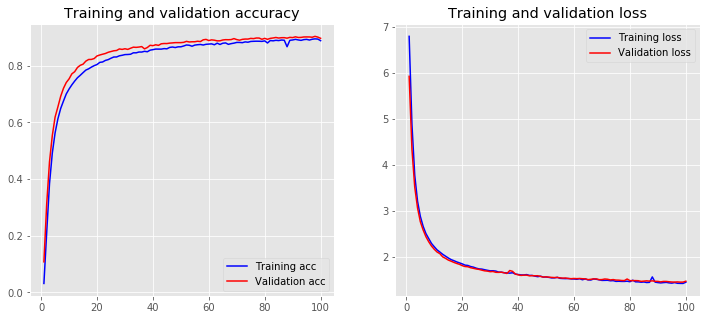

In [62]:
plot_history(history1)

In [63]:
test_score = model1.evaluate(test_pad, y_test, batch_size=256, verbose=1)
print('Test loss: ', test_score[0])
print('Test accuracy: ', test_score[1])

7370/7370 [==============================] - 1s 138us/step
Test loss:  1.4782586405688096
Test accuracy:  0.8948439626551387


### Model 2: ProtCNN (https://www.biorxiv.org/content/10.1101/626507v4.full)

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.

- This network uses residual blocks inspired from [ResNet](https://arxiv.org/abs/1512.03385) architecture which also includes dilated convolutions offering larger receptive field without increasing number of model parameters.

In [0]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization(axis=2)(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=regularizers.l2(0.0001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization(axis=2)(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [0]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(2900, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))(x)

model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 100, 21)      0                                            
__________________________________________________________________________________________________
conv1d_105 (Conv1D)             (None, 100, 128)     2816        input_34[0][0]                   
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 100, 128)     512         conv1d_105[0][0]                 
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 100, 128)     0           batch_normalization_74[0][0]     
____________________________________________________________________________________________

In [0]:
history = model.fit(
    train_ohe, y_train,
    epochs=100, batch_size=256,
    validation_data=(val_ohe, y_val))

Train on 174649 samples, validate on 7359 samples
Epoch 1/100
174649/174649 [==============================] - 63s 358us/step - loss: 1.9146 - acc: 0.7968 - val_loss: 0.9882 - val_acc: 0.9398
Epoch 2/100
174649/174649 [==============================] - 58s 331us/step - loss: 0.7033 - acc: 0.9767 - val_loss: 0.9583 - val_acc: 0.9356
Epoch 3/100
174649/174649 [==============================] - 58s 330us/step - loss: 0.6890 - acc: 0.9728 - val_loss: 1.1462 - val_acc: 0.9225
Epoch 4/100
174649/174649 [==============================] - 58s 330us/step - loss: 0.8760 - acc: 0.9652 - val_loss: 1.2244 - val_acc: 0.9344
Epoch 5/100
174649/174649 [==============================] - 58s 331us/step - loss: 0.9215 - acc: 0.9734 - val_loss: 1.2215 - val_acc: 0.9395
Epoch 6/100
174649/174649 [==============================] - 58s 331us/step - loss: 0.8639 - acc: 0.9789 - val_loss: 1.1608 - val_acc: 0.9376
Epoch 7/100
174649/174649 [==============================] - 58s 330us/step - loss: 0.8273 - acc: 

In [0]:
# saving model weights.
model.save_weights('drive/My Drive/Case_Study/pfam/model.h5')

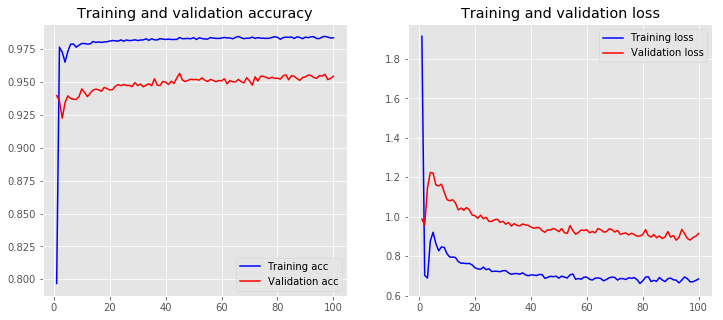

In [0]:
plot_history(history)

In [0]:
test_score = model.evaluate(test_ohe, y_test, batch_size=256, verbose=1)
print('Test loss: ', test_score[0])
print('Test accuracy: ', test_score[1])

7370/7370 [==============================] - 1s 187us/step
Test loss:  0.8928959113610163
Test accuracy:  0.9553595660499511


## 5. Conclusion

In [70]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Test Acc']

x.add_row(['1.', 'Bidirectional LSTM', '0.894'])
x.add_row(['2.', 'ProtCNN', '0.955'])

print(x)

+-------+--------------------+----------+
| Sr.no |       Model        | Test Acc |
+-------+--------------------+----------+
|   1.  | Bidirectional LSTM |  0.894   |
|   2.  |      ProtCNN       |  0.955   |
+-------+--------------------+----------+


### Reference:

- https://www.biorxiv.org/content/10.1101/626507v4.full